In [271]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, jacfwd
import optax
import numpy as np
import matplotlib.pyplot as plt
import flax

In [272]:
# verify JAX is running on GPU and not CPU
print(f"Using the: {jax.devices()[0]}")

Using the: TFRT_CPU_0


In [273]:
# Material Properties 
C1 = 1.0 # Shear modulus
D1 = 10.0 # Bulk modulus
u_pull = 0.5
L, H = 1.0, 0.5 # lenght and height

BC_WEIGHT = 1e5

In [274]:
# Training parameters
LEARNING_RATE = 1e-3
Iterations = 5000
N_Domain = 1000 # number of random points inside the square
N_Boundary = 1000 # number of random points on the boundary

In [275]:
# Introducing NN
from flax import linen as nn # NN library for JAX 

class Model_DEM(nn.Module):
    @nn.compact
    def __call__(self, x):
        # Normalizing input
        x_norm = x / jnp.array([L, H])
        activation = (x_norm - 0.5) * 2.0

        # Create Layers
        activation = nn.Dense(128)(activation)
        activation = nn.tanh(activation)
        activation = nn.Dense(128)(activation)
        activation = nn.tanh(activation)
        activation = nn.Dense(128)(activation)
        activation = nn.tanh(activation)

        # Network Output
        output = nn.Dense(2)(activation) # 2 outputs u and v
        return output 

In [276]:
# Initalize NN
model = Model_DEM()

In [277]:
# Create ky for weight init
key = jax.random.PRNGKey(42)

In [278]:
# Define input size of the NN
# input_first = [1.0, 1.0]
input_first = jnp.ones((2,)) # 2 inputs of x and y

In [279]:
params = model.init(key, input_first) # flex automatically creates a first layer of 2x128

In [280]:
# forward of the network
def forward(params, x):
    return model.apply(params, x)

Now I am introducing two parts way to calculate energy

energy_density_point: will calculate energy equation at a specific point (x, y) 

get_energy_point_batch:uses a vmap to run that calculation across our domain of interest

basically it should create a tensor of 1000x2x2

In [281]:
# energy 
def energy_denstiy_point(params, coordinates):
    # This function calculates strain energy (W) at a specfici point (x, y)

    
    # Calculate displacement gradient u
    #jacfwd computes 2x2 jacobian matrix [du/dx, du/dy] [dv/dx, dv/dy]
    # coordiantes is the x_cord and y_cord
    grad_u = jacfwd(forward, argnums = 1)(params, coordinates)

    # Calculate deformation gradient F
    # F = I + div(u)
    I = jnp.eye(2)
    F = I + grad_u

    # Calculate right Cauchy-Green Deformation tensor
    # C = F^T * F
    C_tensor = jnp.dot(F.T, F) # F.T = F^T as a build in JAX feature

    # Calculate Invariants
    # I1 = Trace of C
    I1 = jnp.trace(C_tensor)

    # J = det(F)
    J = jnp.linalg.det(F) # linalg.det is a built in JAX function that computes determinate of an array

    # Determine and outline Neo Hookean Energy Equation
    W = C1 * (I1 - 2.0 - 2.0 * jnp.log(J)) + D1 * pow((J-1), 2)

    return W


In [282]:
#vmap loops function over a list of points
# None --> means same parameters for every point
# 0 --> split coordinates along each coordiantes
get_energy_density_batch = vmap(energy_denstiy_point, in_axes = (None, 0))

In [283]:
# Repeating the same logic but now for the displacement intsead of W
get_displacement_batch = vmap(forward, in_axes = (None, 0))

Now its time for the boundary condition 

In [284]:
# get the random Y coordinates
key, k1, k2 = jax.random.split(key, 3)

In [285]:
# generate random Y coordinates along the height
y_bc = jax.random.uniform(k1, (N_Boundary, 1), minval = 0, maxval = H) # creates N_Boundary x 1 matrix of random coordinates along the axis

In [286]:
# define left edge (x = 0)
left_x = jnp.zeros((N_Boundary, 1))
left_points = jnp.hstack([left_x, y_bc]) #stacks matrix of x and y coordinates

In [287]:
# clamp left edge: u = 0 v = 0
left_targets = jnp.zeros((N_Boundary, 2))

In [288]:
# Define right edge (x = L)
right_x = jnp.ones((N_Boundary, 1)) * L 
right_points = jnp.hstack([right_x, y_bc])

In [289]:
# right edge target is: u = u_pull v = 0
right_u = jnp.ones((N_Boundary, 1)) * u_pull
right_v = jnp.zeros((N_Boundary, 1))
right_targets = jnp.hstack([right_u, right_v])

In [290]:
# combine data
bc_points = jnp.vstack([left_points, right_points])
bc_targets = jnp.vstack([left_targets, right_targets])

Now set up optimizer and training loop

In [291]:
# loss function 
def loss_function(params, domain_points, bc_poitns, bc_targets):
    energy = get_energy_density_batch(params, domain_points)

    domain_area = L * H
    W = jnp.mean(energy) * domain_area

    u_bc_pred = get_displacement_batch(params, bc_points)

    bc_error = jnp.mean((u_bc_pred - bc_targets)**2)

    total_loss = W + BC_WEIGHT * bc_error

    return total_loss

loss_and_grad = jit(jax.value_and_grad(loss_function))

In [292]:
# Use Adam for optimizer
optimizer = optax.adam(LEARNING_RATE)

In [293]:
# initialize model
model = Model_DEM()

In [294]:
# generate random key for initialization
key, k_init = jax.random.split(key)

In [295]:
# create first input for flax
first_input = jnp.ones((2,))

In [296]:
# create network parameters
params = model.init(k_init, first_input)

In [297]:
# start training loop
loss_history = []
opt_state = optimizer.init(params)
print(f"Starting Flax training for {Iterations} iterations...")

for i in range(Iterations):
    # generate random points in [0, 1] x [0, 1]
    key, subkey = jax.random.split(key)
    domain_points = jax.random.uniform(subkey, (N_Domain, 2))

    domain_points = domain_points * jnp.array([L, H]) # scale points to our dimensions

    loss_val, grads = loss_and_grad(params, domain_points, bc_points, bc_targets)

    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    loss_history.append(loss_val)

    if i % 500 == 0:
        print(f"Iteration {i}: Loss = {loss_val:.5f}")
print(f"Final Loss: {loss_history[-1]:.5f}")

Starting Flax training for 5000 iterations...
Iteration 0: Loss = nan
Iteration 500: Loss = 0.80320
Iteration 1000: Loss = 15.05971
Iteration 1500: Loss = 0.62073
Iteration 2000: Loss = 0.57450
Iteration 2500: Loss = 0.59564
Iteration 3000: Loss = 0.77383
Iteration 3500: Loss = 0.46465
Iteration 4000: Loss = 0.55633
Iteration 4500: Loss = 13.07974
Final Loss: 0.46408


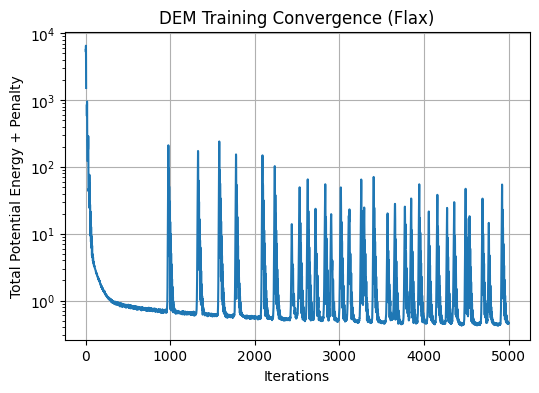

In [298]:
# --- 4. Visualization ---
plt.figure(figsize=(6, 4))
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel("Iterations")
plt.ylabel("Total Potential Energy + Penalty")
plt.title("DEM Training Convergence (Flax)")
plt.grid(True)
plt.show()